In [ ]:
import pandas as pd

In [ ]:
df = pd.read_csv("Austin_Crash_Report_Data_-_Crash_Level_Records_20251111.csv")

/var/folders/2q/dxbhjwx110gds7w9k1xpqr9h0000gn/T/ipykernel_53143/2270934365.py:1: DtypeWarning: Columns (6,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("Austin_Crash_Report_Data_-_Crash_Level_Records_20251111.csv")


In [ ]:
print(df.shape)

(224378, 47)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224378 entries, 0 to 224377
Data columns (total 47 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   ID                                    224378 non-null  object 
 1   Crash ID                              224376 non-null  object 
 2   crash_fatal_fl                        224378 non-null  bool   
 3   case_id                               221445 non-null  object 
 4   Primary address                       224378 non-null  object 
 5   Secondary address                     224376 non-null  object 
 6   rpt_block_num                         194193 non-null  object 
 7   rpt_street_name                       224377 non-null  object 
 8   rpt_street_sfx                        153633 non-null  object 
 9   crash_speed_limit                     224377 non-null  float64
 10  road_constr_zone_fl                   224376 non-null  object 
 11  

In [ ]:
df.head()

ID    Crash ID  crash_fatal_fl    case_id      Primary address  \
0  80,893  15,945,835           False   17-24158   13500 HARRIS RIDGE   
1  76,418  15,860,115           False  171920743   10500 N MOPAC EXPY   
2  76,263  15,857,190           False  171891392     8200 W SH 71 HWY   
3  78,200  15,896,054           False  171620246         1105 N IH 35   
4  74,905  15,828,269           False        NaN  1000 N CONGRESS AVE   

              Secondary address rpt_block_num rpt_street_name rpt_street_sfx  \
0              1000 E HOWARD LN         13500    HARRIS RIDGE            NaN   
1  N N CAPITAL OF TEXAS HWY HWY         10500           MOPAC           EXPY   
2            6600 SILVERMINE DR          8200           SH 71            HWY   
3                100 E 11 TH ST          1105           IH 35            NaN   
4                 100 E 10TH ST          1000        CONGRESS            AVE   

   crash_speed_limit  ... Crash timestamp (US/Central)  \
0               30.0  ...      2017 Sep 05 09:53:00 AM   
1               50.0  ...      2017 Jul 11 11:48:00 AM   
2               55.0  ...      2017 Jul 08 07:30:00 PM   
3               45.0  ...      2017 Jun 11 02:30:00 AM   
4               30.0  ...      2017 Jun 10 08:38:00 AM   

           Crash timestamp  Is deleted  Is temporary record  \
0  2017 Sep 05 02:53:00 PM       False                False   
1  2017 Jul 11 04:48:00 PM       False                False   
2  2017 Jul 09 12:30:00 AM       False                False   
3  2017 Jun 11 07:30:00 AM       False                False   
4  2017 Jun 10 01:38:00 PM       False                False   

   Law enforcement fatality count  Reported street prefix  \
0                               0                     NaN   
1                               0                     NaN   
2                               0                     NaN   
3                               0                     NaN   
4                               0                     NaN   

   Estimated Maximum Comprehensive Cost  Estimated Total Comprehensive Cost  \
0                                20,000                              60,000   
1                               250,000                             250,000   
2                               200,000                             420,000   
3                                20,000                              40,000   
4                                20,000                              20,000   

   Location ID  Location group  
0   76E1554E78             1.0  
1          NaN             NaN  
2  4DBA4B410D1             2.0  
3   29459AF699             1.0  
4   04E5DE7CE3             1.0  

[5 rows x 47 columns]

In [ ]:
df.isna().sum().sort_values(ascending=False).head(15)


Reported street prefix                224378
rpt_street_sfx                         70745
rpt_block_num                          30185
Location group                         20692
Location ID                            20692
longitude                               3385
point                                   3385
latitude                                3384
case_id                                 2933
road_constr_zone_fl                        2
Secondary address                          2
Crash ID                                   2
rpt_street_name                            1
crash_speed_limit                          1
Estimated Total Comprehensive Cost         0
dtype: int64

#### As shown above, all entries are missing values in 'Reported street prefix.' This column will be dropped.

### Layer 1 - Basic Missingness Cleaning

In [ ]:
# Drop fully empty or irrelevant columns
df = df.drop(columns=["Reported street prefix"], errors="ignore")

# Fill minor text fields
df["rpt_street_sfx"] = df["rpt_street_sfx"].fillna("None")

# Drop rows with invalid coordinates
df = df.dropna(subset=["latitude", "longitude"])

# Optional: reset index after dropping
df = df.reset_index(drop=True)


### Layer 2 - Model Readiness Cleaning

In [ ]:
# --- 1. Drop temporary or deleted records ---
df = df[(df["Is temporary record"] == False) & (df["Is deleted"] == False)]

# --- 2. Drop rows missing or invalid coordinates ---
df = df.dropna(subset=["latitude", "longitude"])
df = df[(df["latitude"].between(30.1, 30.5)) & (df["longitude"].between(-97.9, -97.5))]

# --- 3. Drop rows without timestamp (use the correct column name) ---
df = df.dropna(subset=["Crash timestamp (US/Central)"])

# --- 4. Drop duplicate Crash IDs ---
df = df.drop_duplicates(subset=["Crash ID"], keep="first")

# --- 5. Optional: create a subset for cost modeling (Tweedie regression later) ---
df_cost = df.dropna(subset=["Estimated Total Comprehensive Cost"])

# --- 6. Reset index for cleanliness ---
df = df.reset_index(drop=True)
df_cost = df_cost.reset_index(drop=True)


### Sanity Snapshot

In [ ]:
print("ROWS x COLS:", df.shape)
print("Nulls (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))
print("\nColumns & dtypes:")
print(df.dtypes)


ROWS x COLS: (220577, 46)
Nulls (top 10):
rpt_block_num                         28809
Location group                        17266
Location ID                           17266
case_id                                2900
Secondary address                         2
rpt_street_name                           1
micromobility_serious_injury_count        0
pedestrian_death_count                    0
pedestrian_serious_injury_count           0
motorcycle_death_count                    0
dtype: int64

Columns & dtypes:
ID                                       object
Crash ID                                 object
crash_fatal_fl                             bool
case_id                                  object
Primary address                          object
Secondary address                        object
rpt_block_num                            object
rpt_street_name                          object
rpt_street_sfx                           object
crash_speed_limit                       float64
road_c

### Key Integrity Checks

In [ ]:
# Unique IDs (should equal row count)
n_rows = len(df)
n_ids  = df["Crash ID"].nunique()
print(f"Unique Crash IDs: {n_ids} / {n_rows}")

# No temp/deleted flags remain
print("Any temporary records left? ", bool(df["Is temporary record"].sum()))
print("Any deleted records left?   ", bool(df["Is deleted"].sum()))


Unique Crash IDs: 220577 / 220577
Any temporary records left?  False
Any deleted records left?    False


### Coordinates: Range & Outliers

In [ ]:
print("Latitude range:", df["latitude"].min(), "→", df["latitude"].max())
print("Longitude range:", df["longitude"].min(), "→", df["longitude"].max())

# Quick quantiles to spot tails
print(df[["latitude","longitude"]].quantile([0.001, 0.01, 0.99, 0.999]))


Latitude range: 30.10004962 → 30.49975
Longitude range: -97.89998346 → -97.57014781
        latitude  longitude
0.001  30.109699 -97.891253
0.010  30.147112 -97.873946
0.990  30.476685 -97.620104
0.999  30.496747 -97.580787


### Timestamp coverage (min/max) and gaps

In [ ]:
# Parse localized column if you created it; else use the raw column
ts_col = "Crash timestamp (US/Central)"
dt = pd.to_datetime(df[ts_col], errors="coerce")

print("Datetime coverage:")
print("  min:", dt.min())
print("  max:", dt.max())

# Records per year-month (good for spotting missing months)
by_ym = dt.dt.to_period("M").value_counts().sort_index()
print("\nCounts by Year-Month (first/last 12):")
print(pd.concat([by_ym.head(12), by_ym.tail(12)]))


Datetime coverage:
  min: 2010-01-01 00:59:00
  max: 2025-10-28 04:42:00

Counts by Year-Month (first/last 12):
Crash timestamp (US/Central)
2010-01     768
2010-02     888
2010-03    1070
2010-04    1067
2010-05     998
2010-06     974
2010-07     957
2010-08    1038
2010-09     976
2010-10    1209
2010-11    1044
2010-12    1161
2024-11    1030
2024-12    1024
2025-01     948
2025-02     923
2025-03    1049
2025-04     979
2025-05    1072
2025-06     861
2025-07     883
2025-08     905
2025-09     908
2025-10     936
Freq: M, Name: count, dtype: int64


### Hour-of-day profile (should look sensible: AM/PM peaks)

In [ ]:
hours = dt.dt.hour.value_counts().sort_index()
print("Counts by hour 0–23:")
print(hours)


Counts by hour 0–23:
Crash timestamp (US/Central)
0      5528
1      4821
2      6982
3      4033
4      2605
5      3035
6      6003
7      9636
8     10812
9      8953
10     8416
11     9426
12    11732
13    12105
14    11828
15    13307
16    15410
17    17003
18    14701
19    11259
20     9000
21     9041
22     8234
23     6707
Name: count, dtype: int64


### Residual nulls in critical fields (should be zero)

In [ ]:
critical = ["Crash ID", ts_col, "latitude", "longitude"]
print("Residual nulls in critical fields:")
print(df[critical].isna().sum())


Residual nulls in critical fields:
Crash ID                        0
Crash timestamp (US/Central)    0
latitude                        0
longitude                       0
dtype: int64


### Duplicate audit (should be zero)

In [ ]:
dups = df.duplicated(subset=["Crash ID"]).sum()
print("Duplicate Crash IDs after cleaning:", dups)


Duplicate Crash IDs after cleaning: 0


#### Check data type and text formatting causing the issue

In [ ]:
cost_col = "Estimated Total Comprehensive Cost"
print(df[cost_col].dtype)
print(df[cost_col].head(10).tolist())          # peek
print(df[cost_col].astype(str).str[:20].unique()[:10])  # patterns


object
['60,000', '250,000', '420,000', '40,000', '20,000', '100,000', '500,000', '40,000', '330,000', '40,000']
['60,000' '250,000' '420,000' '40,000' '20,000' '100,000' '500,000'
 '330,000' '820,000' '540,000']


#### Alter data type from string to numeric

In [ ]:
# Clean the cost column: remove commas/whitespace, handle negatives-in-parentheses if any
cost_col = "Estimated Total Comprehensive Cost"

cost_clean = (
    df[cost_col].astype(str).str.strip()
      .str.replace(r"^\((.*)\)$", r"-\1", regex=True)   # (123,456) -> -123,456
      .str.replace(",", "", regex=False)                # remove thousands commas
)

df[cost_col] = pd.to_numeric(cost_clean, errors="coerce")

# Optional: store as nullable integer if it's always whole dollars
if df[cost_col].dropna().mod(1).eq(0).all():
    df[cost_col] = df[cost_col].astype("Int64")  # keeps NaN support


### Cost subset health check

In [ ]:
if "Estimated Total Comprehensive Cost" in df.columns:
    cost = pd.to_numeric(df["Estimated Total Comprehensive Cost"], errors="coerce")
    print("Cost non-null:", cost.notna().sum())
    print("Cost > 0:", (cost > 0).sum())
    print(cost.describe())


Cost non-null: 220577
Cost > 0: 220577
count         220577.0
mean     308164.405174
std      739054.719355
min            20000.0
25%            40000.0
50%           100000.0
75%           270000.0
max         42240000.0
Name: Estimated Total Comprehensive Cost, dtype: Float64


### Export Cleaned CSV

In [ ]:
### START CODE: export cleaned dataset ###

# Define output filename (adds "_cleaned" before .csv)
input_file = "Austin_Crash_Report_Data_-_Crash_Level_Records_20251111.csv"
output_file = input_file.replace(".csv", "_cleaned.csv")

# Save cleaned dataframe
df.to_csv(output_file, index=False)

print(f"✅ Cleaned dataset saved successfully as: {output_file}")
print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")

### END CODE ###


✅ Cleaned dataset saved successfully as: Austin_Crash_Report_Data_-_Crash_Level_Records_20251111_cleaned.csv
Shape: 220577 rows × 46 columns


## Summary — November 11

I was responsible for the initial data preparation and validation of the Austin Crash dataset.

### Exploration and Structure Check
The dataset contained approximately 224,000 crash records across 47 columns. I verified its structure, data types, and missingness, confirming that it captured detailed crash-level information such as timestamps, geographic coordinates, roadway context, and cost estimates.

### Cleaning and Standardization
I removed non-informative or redundant fields, including the fully empty **Reported street prefix** column and rows flagged as **temporary** or **deleted**.  
Invalid or missing coordinates were filtered out, restricting the dataset to valid Austin bounds (latitude 30.1–30.5, longitude −97.9–−97.5).  
Timestamps were standardized using **Crash timestamp (US/Central)** and localized to the *America/Chicago* timezone to ensure consistency across daylight-saving transitions.  
The **Estimated Total Comprehensive Cost** field, originally stored as text (e.g., “60,000”), was cleaned and converted to numeric values.  
Duplicate crash IDs were removed, and the index was reset.

### Verification
Post-cleaning validation confirmed that approximately 220,000 valid records remain.  
No duplicates or missing values exist in critical fields such as crash ID, timestamp, latitude, or longitude.  
Coordinates and timestamps fall within expected ranges, and the cost field is fully numeric and ready for downstream modeling.

## Deliverable
The final output, **Austin_Crash_Report_Data_-_Crash_Level_Records_20251111_cleaned.csv**, contains the cleaned and verified dataset.  
It is now model-ready for spatiotemporal aggregation, feature engineering, and crash-risk modeling.


**Part 2: Ishrak**

In [ ]:
import pandas as pd

# ============
# Config
# ============
INPUT_PATH = "Austin_Crash_Report_Data_-_Crash_Level_Records_20251111_cleaned.csv"
OUTPUT_PATH = "Austin_Crash_Report_with_time_features.csv"
TIMESTAMP_COL = "Crash timestamp (US/Central)"

# ============
# Load
# ============
# low_memory=False to avoid mixed-type warnings on wide CSVs
df = pd.read_csv(INPUT_PATH, low_memory=False)

# ============
# Parse timestamp
# ============
df[TIMESTAMP_COL] = pd.to_datetime(df[TIMESTAMP_COL], errors="coerce")

# ============
# Time-based features
# ============
df["hour"] = df[TIMESTAMP_COL].dt.hour
df["day"] = df[TIMESTAMP_COL].dt.day
df["month"] = df[TIMESTAMP_COL].dt.month
df["year"] = df[TIMESTAMP_COL].dt.year
df["weekday"] = df[TIMESTAMP_COL].dt.day_name()
df["is_weekend"] = df[TIMESTAMP_COL].dt.weekday >= 5  # Sat=5, Sun=6

# ============
# Holiday indicator
# Try 'holidays' package; if unavailable, fall back to a manual list of major US holidays (2017–2023)
# ============
is_holiday_series = pd.Series(False, index=df.index)

try:
    import holidays  # type: ignore

    us_holidays = holidays.country_holidays("US", years=range(2017, 2024))
    # Compare only by date
    crash_dates = df[TIMESTAMP_COL].dt.date
    is_holiday_series = crash_dates.astype("O").isin(set(us_holidays.keys()))
except Exception:
    # Minimal manual list of major US holidays (New Year’s Day, Independence Day, Thanksgiving, Christmas)
    manual_holidays = pd.to_datetime([
        # 2017
        "2017-01-01","2017-07-04","2017-11-23","2017-12-25",
        # 2018
        "2018-01-01","2018-07-04","2018-11-22","2018-12-25",
        # 2019
        "2019-01-01","2019-07-04","2019-11-28","2019-12-25",
        # 2020
        "2020-01-01","2020-07-04","2020-11-26","2020-12-25",
        # 2021
        "2021-01-01","2021-07-04","2021-11-25","2021-12-25",
        # 2022
        "2022-01-01","2022-07-04","2022-11-24","2022-12-25",
        # 2023
        "2023-01-01","2023-07-04","2023-11-23","2023-12-25",
    ])
    crash_dates = df[TIMESTAMP_COL].dt.normalize()  # midnight of each date
    is_holiday_series = crash_dates.isin(manual_holidays)

df["is_holiday"] = is_holiday_series

# ============
# Save
# ============
df.to_csv(OUTPUT_PATH, index=False)

print(f"Saved updated file to: {OUTPUT_PATH}")

Saved updated file to: Austin_Crash_Report_with_time_features.csv


First the dataset “Austin_Crash_Report_Data_-_Crash_Level_Records_20251111_cleaned.csv” was loaded and then focus was on the column **“Crash timestamp (US/Central)”**, which records the time of each crash. I converted this column from text to a proper datetime format so that time-based components could be easily extracted.

Next, I generated several new features: **hour**, **day**, **month**, **year**, **weekday**, and a **weekend indicator** that marks crashes occurring on Saturdays or Sundays. To capture special dates, I also added a **holiday indicator** by manually defining major U.S. holidays (New Year’s Day, Independence Day, Thanksgiving, and Christmas) from 2017 to 2023 and checking whether each crash date matched any of them.

Finally, I saved the enhanced dataset as **“Austin_Crash_Report_with_time_features.csv”**, which now includes all original columns plus these seven new time-based features. These additions allow for more detailed temporal analysis of crash patterns across different times, days, and holidays.


# **Aggregate Crash Data Into Grids**


In [ ]:
!pip install contextily
!pip install h3 geopandas

In [ ]:
import pandas as pd
import h3
from h3 import cell_to_boundary
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx
import matplotlib.colors as mcolors
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# df_3 = pd.read_csv("crashdata.csv")

df_3 = pd.read_csv("Austin_Crash_Report_with_time_features.csv")


/var/folders/2q/dxbhjwx110gds7w9k1xpqr9h0000gn/T/ipykernel_53143/2769515530.py:3: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_3 = pd.read_csv("Austin_Crash_Report_with_time_features.csv")


In [ ]:
df_3.head()

ID    Crash ID  crash_fatal_fl    case_id      Primary address  \
0  80,893  15,945,835           False   17-24158   13500 HARRIS RIDGE   
1  76,418  15,860,115           False  171920743   10500 N MOPAC EXPY   
2  76,263  15,857,190           False  171891392     8200 W SH 71 HWY   
3  78,200  15,896,054           False  171620246         1105 N IH 35   
4  74,905  15,828,269           False        NaN  1000 N CONGRESS AVE   

              Secondary address rpt_block_num rpt_street_name rpt_street_sfx  \
0              1000 E HOWARD LN         13500    HARRIS RIDGE            NaN   
1  N N CAPITAL OF TEXAS HWY HWY         10500           MOPAC           EXPY   
2            6600 SILVERMINE DR          8200           SH 71            HWY   
3                100 E 11 TH ST          1105           IH 35            NaN   
4                 100 E 10TH ST          1000        CONGRESS            AVE   

   crash_speed_limit  ...  Estimated Total Comprehensive Cost  Location ID  \
0               30.0  ...                               60000   76E1554E78   
1               50.0  ...                              250000          NaN   
2               55.0  ...                              420000  4DBA4B410D1   
3               45.0  ...                               40000   29459AF699   
4               30.0  ...                               20000   04E5DE7CE3   

   Location group  hour  day  month  year   weekday  is_weekend  is_holiday  
0             1.0     9    5      9  2017   Tuesday       False       False  
1             NaN    11   11      7  2017   Tuesday       False       False  
2             2.0    19    8      7  2017  Saturday        True       False  
3             1.0     2   11      6  2017    Sunday        True       False  
4             1.0     8   10      6  2017  Saturday        True       False  

[5 rows x 53 columns]

**Create index for resolution level 7,8,9**

In [ ]:
#resolution 7 creates hexagons that cover 5 square km
df_3['h3_index_7'] = df_3.apply(lambda row: h3.latlng_to_cell(row['latitude'], row['longitude'], 7), axis=1)

#resolution 8 creates hexagons that cover 1 square km
df_3['h3_index_8'] = df_3.apply(lambda row: h3.latlng_to_cell(row['latitude'], row['longitude'], 8), axis=1)

#resolution 9 creates hexagons that cover 0.1 sq km
df_3['h3_index_9'] = df_3.apply(lambda row: h3.latlng_to_cell(row['latitude'], row['longitude'], 9), axis=1)

In [ ]:
# # Count unique hexes at each resolution
# for res in ['h3_index_7', 'h3_index_8', 'h3_index_9']:
#     unique_count = df_3[res].nunique()
#     print(f"Resolution {res}: {unique_count} unique hexagons")

In [ ]:
#takes index and builds teh hexagons
def h3_to_polygon(h3_index):
    coords = cell_to_boundary(h3_index)
    return Polygon([(lng, lat) for lat, lng in coords])


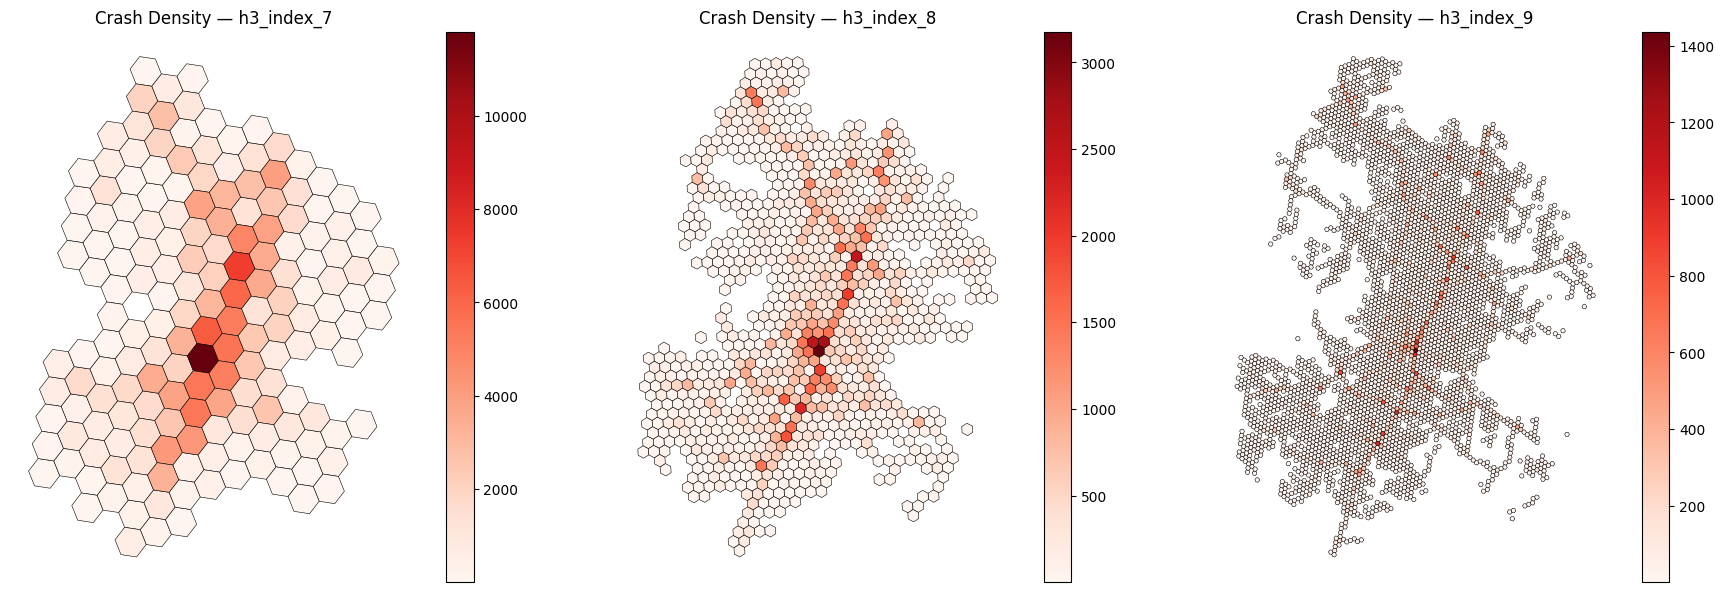

In [ ]:
resolutions = ['h3_index_7', 'h3_index_8', 'h3_index_9']

hex_counts_dict = {}
for res in resolutions:
    hex_counts = df_3.groupby(res).size().reset_index(name='crash_count')
    hex_counts['geometry'] = hex_counts[res].apply(h3_to_polygon)
    gdf = gpd.GeoDataFrame(hex_counts, geometry='geometry', crs='EPSG:4326')
    hex_counts_dict[res] = gdf

# Plot side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, res in zip(axes, resolutions):
    hex_counts_dict[res].plot(
        column='crash_count',
        cmap='Reds',
        linewidth=0.4,
        edgecolor='black',
        legend=True,
        ax=ax
    )
    ax.set_title(f"Crash Density — {res}")
    ax.axis('off')
plt.tight_layout()
plt.show()


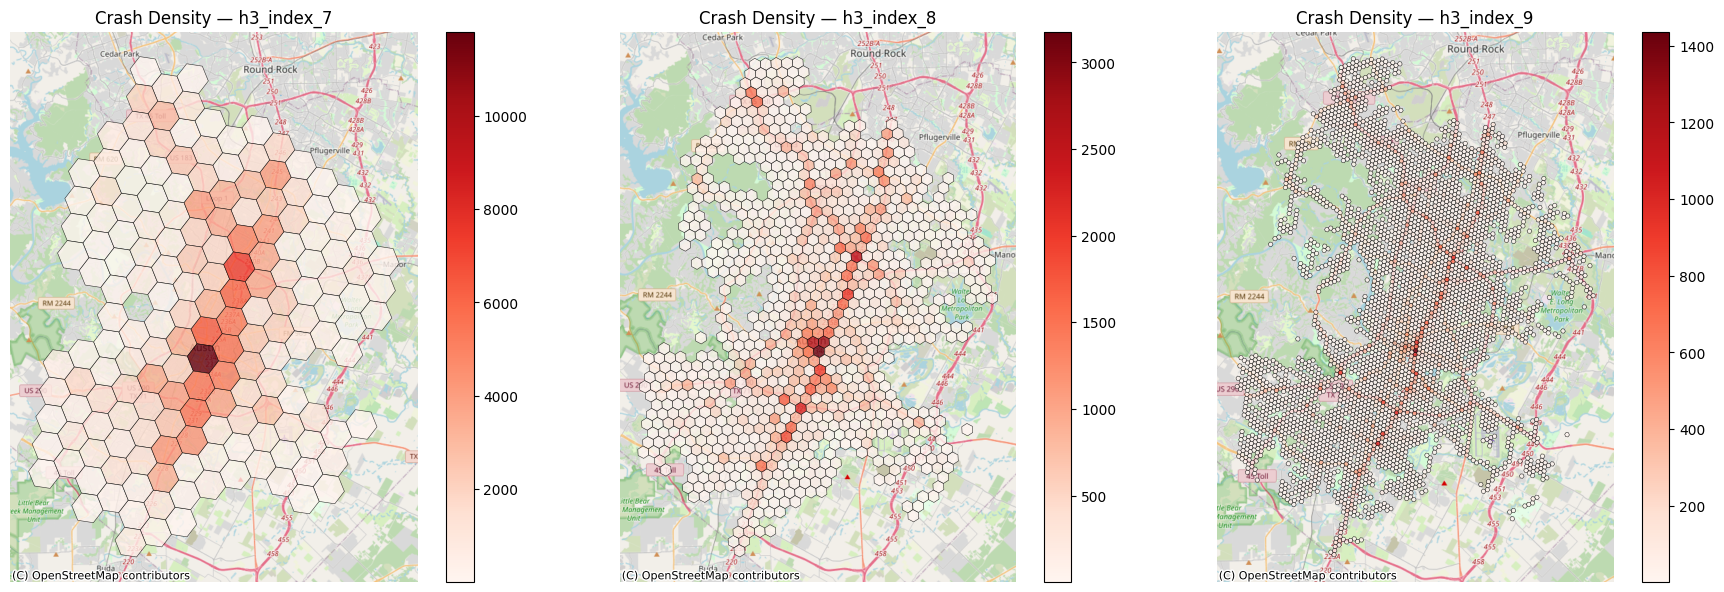

In [ ]:
# Reproject each GeoDataFrame to Web Mercator
for res in resolutions:
    hex_counts_dict[res] = hex_counts_dict[res].to_crs(epsg=3857)

# Plot again with OpenStreetMap background
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, res in zip(axes, resolutions):
    gdf = hex_counts_dict[res]
    gdf.plot(
        column='crash_count',
        cmap='Reds',
        linewidth=0.4,
        edgecolor='black',
        legend=True,
        alpha=0.8,
        ax=ax
    )
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_title(f"Crash Density — {res}", fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

Adding resolution levels 10,11, and 12.

In [ ]:
#resolution 10 creates hexagons that cover 0.02ish square km
df_3['h3_index_10'] = df_3.apply(lambda row: h3.latlng_to_cell(row['latitude'], row['longitude'], 10), axis=1)

#resolution 11 creates hexagons that cover 0.002ish square km
df_3['h3_index_11'] = df_3.apply(lambda row: h3.latlng_to_cell(row['latitude'], row['longitude'], 11), axis=1)

#resolution 12 creates hexagons that cover 0.0002ish sq km (this is like one block)
df_3['h3_index_12'] = df_3.apply(lambda row: h3.latlng_to_cell(row['latitude'], row['longitude'], 12), axis=1)

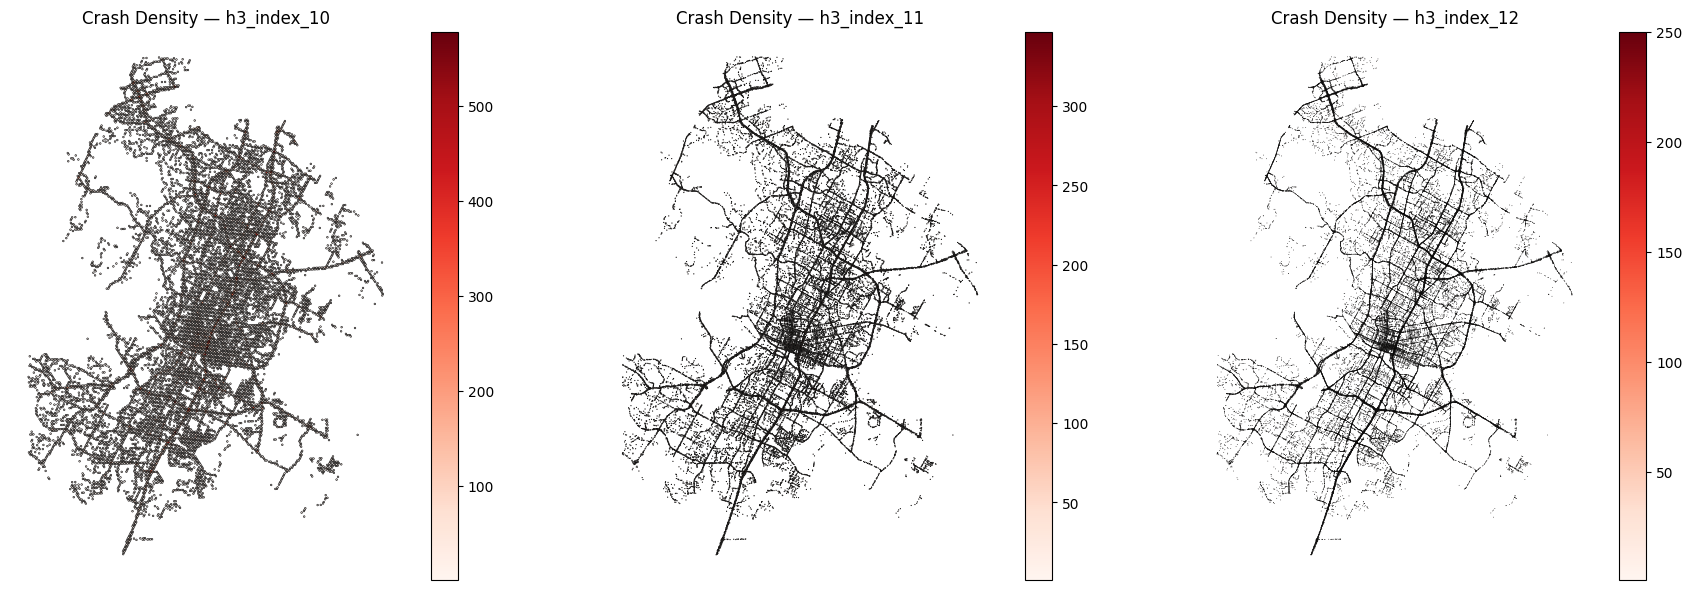

In [ ]:
resolutions_2 = ['h3_index_10', 'h3_index_11', 'h3_index_12']

hex_counts_dict = {}
for res in resolutions_2:
    hex_counts = df_3.groupby(res).size().reset_index(name='crash_count')
    hex_counts['geometry'] = hex_counts[res].apply(h3_to_polygon)
    gdf = gpd.GeoDataFrame(hex_counts, geometry='geometry', crs='EPSG:4326')
    hex_counts_dict[res] = gdf

# Plot side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 6))
for ax, res in zip(axes, resolutions_2):
    hex_counts_dict[res].plot(
        column='crash_count',
        cmap='Reds',
        linewidth=0.4,
        edgecolor='black',
        legend=True,
        ax=ax
    )
    ax.set_title(f"Crash Density — {res}")
    ax.axis('off')
plt.tight_layout()
plt.show()

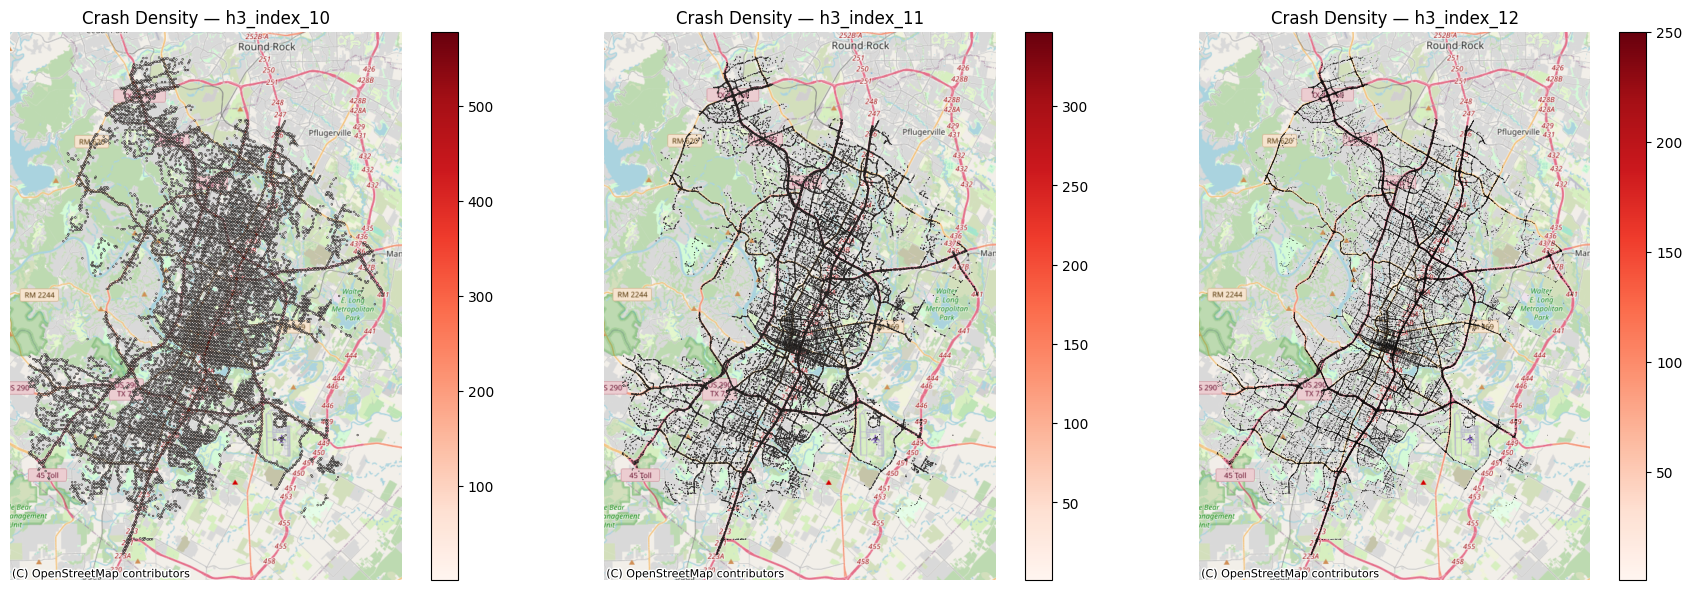

In [ ]:
# Reproject each GeoDataFrame to Web Mercator
for res in resolutions_2:
    hex_counts_dict[res] = hex_counts_dict[res].to_crs(epsg=3857)

# Plot again with OpenStreetMap background
fig, axes = plt.subplots(1, 3, figsize=(18, 6))


for ax, res in zip(axes, resolutions_2):
    gdf = hex_counts_dict[res]
    gdf.plot(
        column='crash_count',
        cmap='Reds',
        linewidth=0.4,
        edgecolor='black',
        legend=True,
        alpha=0.8,
        ax=ax
    )
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_title(f"Crash Density — {res}", fontsize=12)
    ax.axis('off')

plt.tight_layout()
plt.show()

**Figure out which resolution to use**

Distribution of Crashes at Each Resolution Level

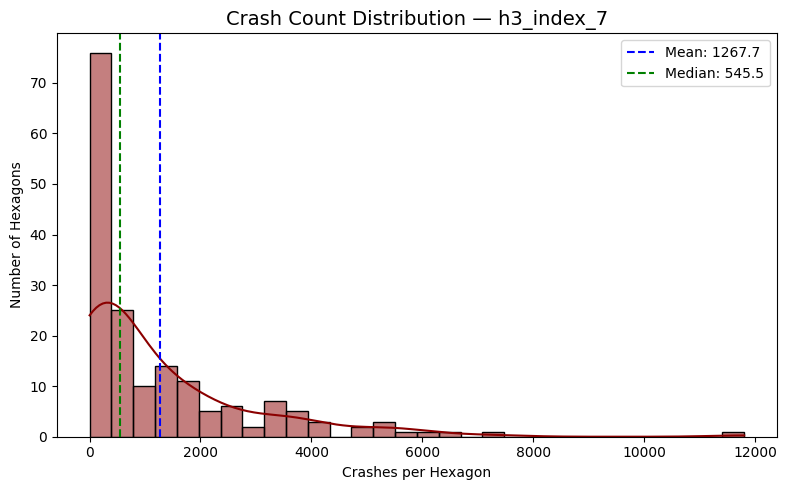

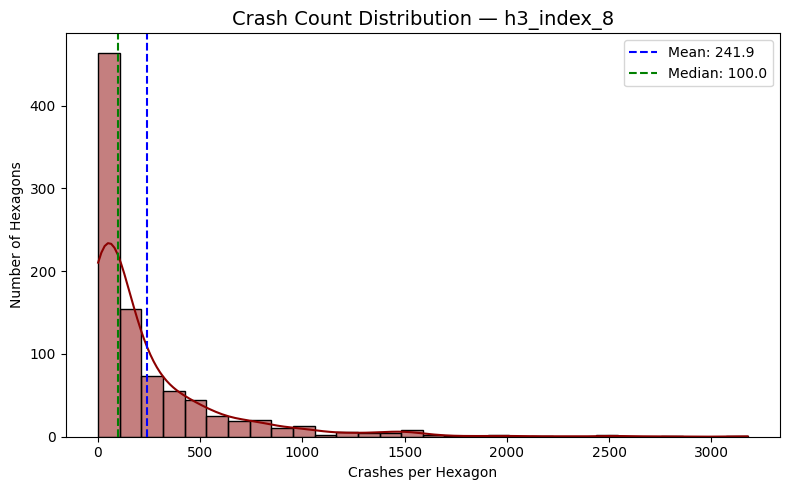

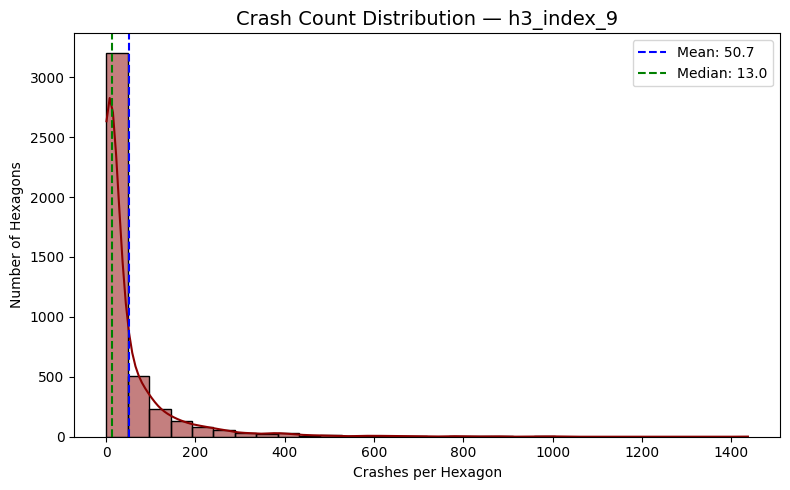

In [ ]:
for res in resolutions:
    # Count crashes per hex
    crash_counts = df_3.groupby(res).size().reset_index(name='crash_count')

    # Create a figure for this resolution
    plt.figure(figsize=(8, 5))
    sns.histplot(crash_counts['crash_count'], bins=30, kde=True, color='darkred')

    # Add title and labels
    plt.title(f"Crash Count Distribution — {res}", fontsize=14)
    plt.xlabel("Crashes per Hexagon")
    plt.ylabel("Number of Hexagons")

    # Add mean and median lines
    mean_val = crash_counts['crash_count'].mean()
    median_val = crash_counts['crash_count'].median()
    plt.axvline(mean_val, color='blue', linestyle='--', label=f"Mean: {mean_val:.1f}")
    plt.axvline(median_val, color='green', linestyle='--', label=f"Median: {median_val:.1f}")
    plt.legend()

    # Show plot
    plt.tight_layout()
    plt.show()


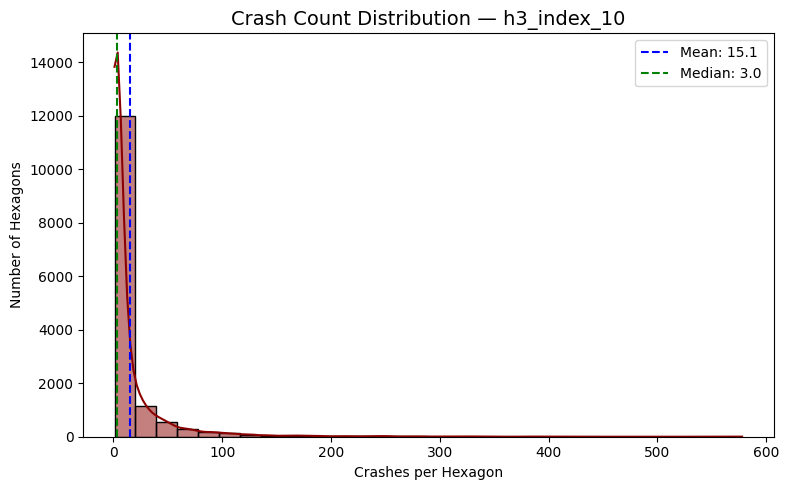

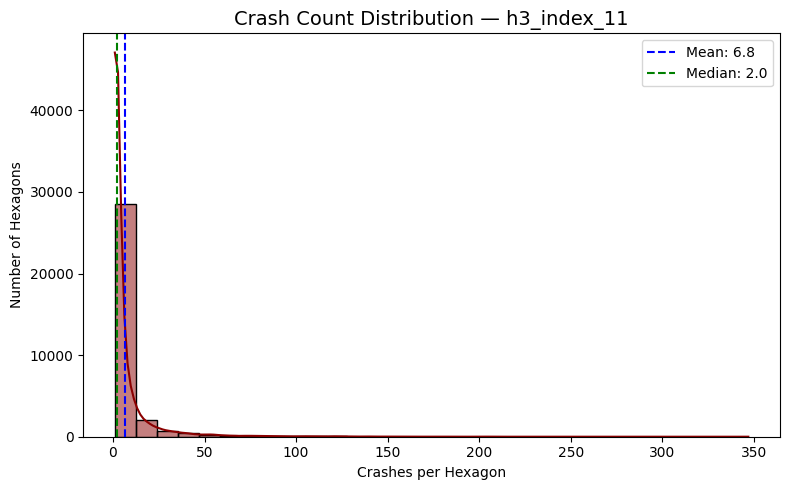

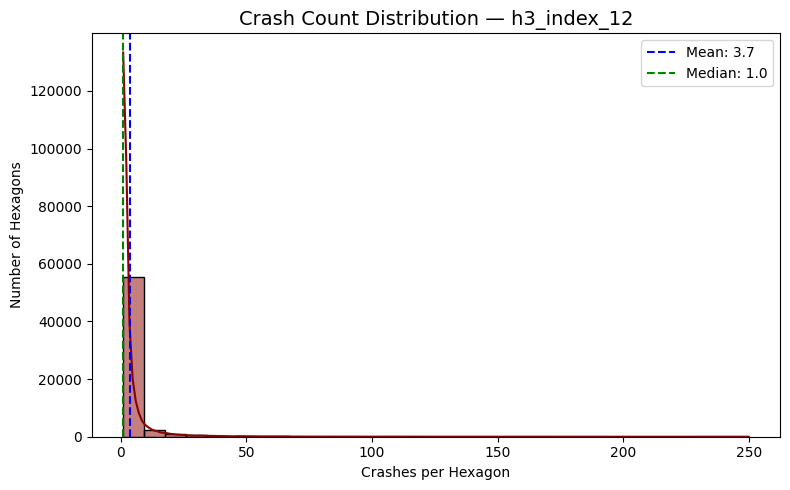

In [ ]:
for res in resolutions_2:
    # Count crashes per hex
    crash_counts = df_3.groupby(res).size().reset_index(name='crash_count')

    # Create a figure for this resolution
    plt.figure(figsize=(8, 5))
    sns.histplot(crash_counts['crash_count'], bins=30, kde=True, color='darkred')

    # Add title and labels
    plt.title(f"Crash Count Distribution — {res}", fontsize=14)
    plt.xlabel("Crashes per Hexagon")
    plt.ylabel("Number of Hexagons")

    # Add mean and median lines
    mean_val = crash_counts['crash_count'].mean()
    median_val = crash_counts['crash_count'].median()
    plt.axvline(mean_val, color='blue', linestyle='--', label=f"Mean: {mean_val:.1f}")
    plt.axvline(median_val, color='green', linestyle='--', label=f"Median: {median_val:.1f}")
    plt.legend()

    # Show plot
    plt.tight_layout()
    plt.show()

In [ ]:
df_3.columns

Index(['ID', 'Crash ID', 'crash_fatal_fl', 'case_id', 'Primary address',
       'Secondary address', 'rpt_block_num', 'rpt_street_name',
       'rpt_street_sfx', 'crash_speed_limit', 'road_constr_zone_fl',
       'latitude', 'longitude', 'crash_sev_id', 'sus_serious_injry_cnt',
       'nonincap_injry_cnt', 'poss_injry_cnt', 'non_injry_cnt',
       'unkn_injry_cnt', 'tot_injry_cnt', 'death_cnt', 'units_involved',
       'point', 'motor_vehicle_death_count',
       'motor_vehicle_serious_injury_count', 'bicycle_death_count',
       'bicycle_serious_injury_count', 'pedestrian_death_count',
       'pedestrian_serious_injury_count', 'motorcycle_death_count',
       'motorcycle_serious_injury_count', 'other_death_count',
       'other_serious_injury_count', 'onsys_fl', 'private_dr_fl',
       'micromobility_serious_injury_count', 'micromobility_death_count',
       'Crash timestamp (US/Central)', 'Crash timestamp', 'Is deleted',
       'Is temporary record', 'Law enforcement fatality count',

In [ ]:
#export csv of updated dataframe
df_3.to_csv("crash_data_v3.csv", index=False)


**Part 4: Franco**

Engineer lagged counts, rolling means, and recent-incident indicators. (Data Lead + Visualization Lead).

In [1]:
import pandas as pd
df_raw = pd.read_csv("crash_data_v3.csv")

display(df_raw.head(1)[['longitude', 'latitude']])

/var/folders/2q/dxbhjwx110gds7w9k1xpqr9h0000gn/T/ipykernel_56382/3455642664.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv("crash_data_v3.csv")


longitude   latitude
0 -97.649423  30.408168

In [2]:
print(df_raw.shape)

(220577, 59)


Converted crash timestamps into 30-minute time bins and kept only valid records.

Selected all relevant crash-level variables and prepared them for aggregation (including converting booleans to 0/1 and one-hot-encoding weekday).

Added crash_count and crash_cost explicitly so we could track how many crashes and how much cost occurred in each bin.

Aggregated the dataset to H3 hexagon (resolution 8) × 30-minute time bins, summing injury counts, boolean flags, weekday dummies, and costs, while averaging speed, severity, and location group.

In [3]:
df = df_raw.copy()

# ---------------------------
# Ensure datetime and time bins
# ---------------------------
df['Crash timestamp'] = pd.to_datetime(df['Crash timestamp'], errors='coerce')
df = df.dropna(subset=['Crash timestamp'])  # keep only valid timestamps

# 🔹 NEW: limit to recent years to control grid size
df = df[df['Crash timestamp'] >= "2021-01-01"]   # <--- ADDED LINE (cut to ~4–5 years)

# 🔹 CHANGED: use 1-hour bins instead of 30 minutes
time_bin = "1H"                                  # <--- CHANGED from "30min"
df['time_bin'] = df['Crash timestamp'].dt.floor(time_bin)

# ---------------------------
# Define variable groups
# ---------------------------

# Variables that should be SUMMED over crashes in a hex-timebin
numeric_sum_cols = [
    'sus_serious_injry_cnt', 'nonincap_injry_cnt', 'poss_injry_cnt',
    'non_injry_cnt', 'unkn_injry_cnt', 'tot_injry_cnt', 'death_cnt',
    'motor_vehicle_death_count', 'motor_vehicle_serious_injury_count',
    'bicycle_death_count', 'bicycle_serious_injury_count',
    'pedestrian_death_count', 'pedestrian_serious_injury_count',
    'motorcycle_death_count', 'motorcycle_serious_injury_count',
    'micromobility_serious_injury_count', 'micromobility_death_count',
    'Law enforcement fatality count',
    'Estimated Total Comprehensive Cost'
]

# Variables that should be MEANED in a hex-timebin
numeric_mean_cols = [
    'crash_speed_limit', 'crash_sev_id', 'Location group'
]

# Boolean fields → convert to 0/1 → then sum per bin
bool_cols = [
    'crash_fatal_fl', 'road_constr_zone_fl', 'private_dr_fl',
    'onsys_fl', 'is_weekend', 'is_holiday',
    'Is deleted', 'Is temporary record'
]

# Categorical (one-hot)
cat_cols = ['weekday']

# ---------------------------
# Subset needed columns
# ---------------------------
cols_needed = (
    ['h3_index_8', 'time_bin'] +
    numeric_sum_cols +
    numeric_mean_cols +
    bool_cols +
    cat_cols
)

df_small = df[cols_needed].copy()

# ---------------------------
# Convert booleans to integers
# ---------------------------
for col in bool_cols:
    df_small[col] = df_small[col].astype(int)

# ---------------------------
# One-hot encode weekday
# ---------------------------
df_small = pd.get_dummies(df_small, columns=cat_cols, prefix=cat_cols)

weekday_dummy_cols = [c for c in df_small.columns if c.startswith("weekday_")]

# ---------------------------
# Add crash_count and crash_cost explicitly
# ---------------------------
df_small["crash_count"] = 1  # one row = one crash
df_small["crash_cost"] = df_small["Estimated Total Comprehensive Cost"]  # already numeric

# ---------------------------
# BUILD AGGREGATION DICTIONARY
# ---------------------------
agg_dict = {}

# sum columns
for c in numeric_sum_cols:
    agg_dict[c] = "sum"

# mean columns
for c in numeric_mean_cols:
    agg_dict[c] = "mean"

# boolean sums
for c in bool_cols:
    agg_dict[c] = "sum"

# weekday_dummy sums
for c in weekday_dummy_cols:
    agg_dict[c] = "sum"

# NEW crash count + crash cost
agg_dict["crash_count"] = "sum"
agg_dict["crash_cost"] = "sum"

# ---------------------------
# GROUP BY HEX + TIMEBIN
# ---------------------------
grouped = (
    df_small.groupby(["h3_index_8", "time_bin"])
            .agg(agg_dict)
            .reset_index()
)

print("Grouped shape:", grouped.shape)
print(grouped.head())



/var/folders/2q/dxbhjwx110gds7w9k1xpqr9h0000gn/T/ipykernel_56382/1881958002.py:6: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Crash timestamp'] = pd.to_datetime(df['Crash timestamp'], errors='coerce')


Grouped shape: (60129, 41)
        h3_index_8            time_bin  sus_serious_injry_cnt  \
0  884898c903fffff 2024-06-20 15:00:00                      0   
1  884898c907fffff 2021-01-02 22:00:00                      1   
2  884898c907fffff 2021-03-18 22:00:00                      0   
3  884898c907fffff 2021-06-15 12:00:00                      0   
4  884898c907fffff 2021-06-24 04:00:00                      0   

   nonincap_injry_cnt  poss_injry_cnt  non_injry_cnt  unkn_injry_cnt  \
0                   0               0              1               0   
1                   0               0              0               0   
2                   2               0              0               0   
3                   0               0              2               0   
4                   0               2              0               0   

   tot_injry_cnt  death_cnt  motor_vehicle_death_count  ...  \
0              0          0                          0  ...   
1              1       

/var/folders/2q/dxbhjwx110gds7w9k1xpqr9h0000gn/T/ipykernel_56382/1881958002.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df['time_bin'] = df['Crash timestamp'].dt.floor(time_bin)


In [4]:
print("\n[Grid Expansion] Filtering hexes and creating full hex × time grid...")

# Ensure datetime type
grouped['time_bin'] = pd.to_datetime(grouped['time_bin'])

# 1) Filter to hexes with at least 10 crashes overall
hex_totals = grouped.groupby("h3_index_8")["crash_count"].sum()
good_hexes = hex_totals[hex_totals >= 10].index  # you can adjust 10 → 5 or 20 if needed

grouped = grouped[grouped["h3_index_8"].isin(good_hexes)].copy()
print("Kept hexes with >=10 crashes. New grouped shape:", grouped.shape)

# 2) Build full time index for 2021+ using 1H bins
full_time_index = pd.date_range(
    start=grouped['time_bin'].min(),
    end=grouped['time_bin'].max(),
    freq=time_bin  # "1H"
)

hexes = grouped['h3_index_8'].unique()
num_hexes = len(hexes)
num_bins = len(full_time_index)
approx_rows = num_hexes * num_bins

print(f"Hexes: {num_hexes}, Time bins: {num_bins}, Approx rows: {approx_rows:,}")

# Safety limit: you can bump this if your machine can handle more
MAX_ROWS = 50_000_000

if approx_rows > MAX_ROWS:
    print(f"⚠️ Grid would create ~{approx_rows:,} rows (> {MAX_ROWS:,}).")
    print("   → Consider raising the crash threshold (e.g., >=20), shrinking years, or coarsening time_bin.")
    print("   For now, skipping full grid expansion to avoid killing the kernel.")
else:
    # 3) Create full grid: all (hex, time_bin)
    full_index = pd.MultiIndex.from_product(
        [hexes, full_time_index],
        names=['h3_index_8', 'time_bin']
    )
    grid_df = full_index.to_frame(index=False)

    print("Grid size (hex × time):", grid_df.shape)

    # 4) Merge crash aggregates onto the full grid
    grouped_full = grid_df.merge(
        grouped,
        on=['h3_index_8', 'time_bin'],
        how='left'
    )

    # 5) Fill crash_count and crash_cost for "no-crash" bins
    grouped_full['crash_count'] = grouped_full['crash_count'].fillna(0).astype(int)
    grouped_full['crash_cost'] = grouped_full['crash_cost'].fillna(0.0)

    # 6) Fill other numeric cols with 0 where appropriate
    numeric_cols = grouped_full.select_dtypes(include=['number']).columns.tolist()
    for col in numeric_cols:
        if col not in ['crash_count', 'crash_cost']:
            grouped_full[col] = grouped_full[col].fillna(0)

    grouped = grouped_full

    print("Expanded grouped shape:", grouped.shape)
    print("crash_count value counts:")
    print(grouped['crash_count'].value_counts().head())




[Grid Expansion] Filtering hexes and creating full hex × time grid...
Kept hexes with >=10 crashes. New grouped shape: (59184, 41)
Hexes: 604, Time bins: 42274, Approx rows: 25,533,496


/var/folders/2q/dxbhjwx110gds7w9k1xpqr9h0000gn/T/ipykernel_56382/2052372009.py:14: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  full_time_index = pd.date_range(


Grid size (hex × time): (25533496, 2)
Expanded grouped shape: (25533496, 41)
crash_count value counts:
crash_count
0    25474312
1       58779
2         398
3           7
Name: count, dtype: int64


**Lags**

Sorted the dataset within each H3 hexagon by time so that temporal relationships are consistent.

For each hexagon, created lag features by shifting crash counts back by 1, 2, 4, and 8 time bins (capturing 30 minutes to 4 hours of recent history).

Filled missing lag values with zero to represent no recent crashes.

Combined all hex-level results back into a single enhanced dataset with these new temporal features.

**Rolling Mean Features**

For each hexagon, sorted its crash time series to ensure the correct temporal order.

Computed rolling mean crash rates over multiple window sizes (1 hour, 2 hours, 6 hours, and 24 hours).

These rolling averages smooth out noise and capture short-term and day-long crash activity trends.

Combined all processed hexagons back into one dataset containing the new rolling features.

**Rolling Features**

For each hexagon, sorted its crash time series to ensure the correct temporal order.

Computed rolling mean crash rates over multiple window sizes (1 hour, 2 hours, 6 hours, and 24 hours).

These rolling averages smooth out noise and capture short-term and day-long crash activity trends.

Combined all processed hexagons back into one dataset containing the new rolling features.

We organized the full feature table by sorting it in hexagon-time order and then standardizing all column types. Numeric features that represent counts were filled with zeros and cast as integers, while averaged and continuous variables were set as floats. Missing values across lag, rolling, and recency features were also filled appropriately. Finally, we ensured all columns had consistent types and saved the entire dataset as a compact Parquet file ready for modeling.

# CRASHES HERE


In [ ]:
!pip install pyarrow


In [5]:
# ============================================
# Part 4 (Revised) – Leak-free hex×hour crash panel (no weather)
# ============================================

import pandas as pd
import numpy as np
import gc

CRASH_FILE = "crash_data_v3.csv"
OUTPUT_PANEL = "model_ready_hex1hr_leakfree.pkl.gz"

df_raw = pd.read_csv(CRASH_FILE)
print("Raw crash_data_v3 shape:", df_raw.shape)

# Timestamp + filter
df_raw["Crash timestamp"] = pd.to_datetime(df_raw["Crash timestamp"], errors="coerce")
df_raw = df_raw.dropna(subset=["Crash timestamp"])
df_raw = df_raw[df_raw["Crash timestamp"] >= "2021-01-01"].copy()
print("After date filter (>= 2021):", df_raw.shape)

# 1-hour bins
df_raw["time_bin"] = df_raw["Crash timestamp"].dt.floor("1H")

# Hex check
if "h3_index_8" not in df_raw.columns:
    raise ValueError("Expected 'h3_index_8' in crash_data_v3.csv")

# Keep hexes with at least N crashes
MIN_CRASHES_PER_HEX = 10
hex_totals = df_raw.groupby("h3_index_8")["Crash ID"].size()
good_hexes = hex_totals[hex_totals >= MIN_CRASHES_PER_HEX].index
df_raw = df_raw[df_raw["h3_index_8"].isin(good_hexes)].copy()

print("Hexes with >=10 crashes:", df_raw["h3_index_8"].nunique())
print("Crash rows after hex filter:", df_raw.shape)

# ---- build full hex × time grid (exposure) ----
t_min = df_raw["time_bin"].min().floor("1H")
t_max = df_raw["time_bin"].max().ceil("1H")
time_index = pd.date_range(start=t_min, end=t_max, freq="1H")

hexes = df_raw["h3_index_8"].unique()
full_index = pd.MultiIndex.from_product(
    [hexes, time_index],
    names=["h3_index_8", "time_bin"]
)

panel = full_index.to_frame(index=False)
panel["time_bin"] = pd.to_datetime(panel["time_bin"])

print("Exposure panel shape:", panel.shape)

# ---- static hex features (no time leakage) ----
if "crash_speed_limit" in df_raw.columns:
    speed_per_hex = (
        df_raw[["h3_index_8", "crash_speed_limit"]]
        .dropna()
        .groupby("h3_index_8", as_index=False)["crash_speed_limit"]
        .median()
    )
    panel = panel.merge(speed_per_hex, on="h3_index_8", how="left")

if "Location group" in df_raw.columns:
    loc_per_hex = (
        df_raw[["h3_index_8", "Location group"]]
        .dropna()
        .groupby("h3_index_8", as_index=False)["Location group"]
        .agg(lambda x: x.value_counts().index[0])
    )
    panel = panel.merge(loc_per_hex, on="h3_index_8", how="left")

print("After static hex features:", panel.shape)

# ---- aggregate crashes per hex×hour, join LAST ----
crash_agg = (
    df_raw
    .groupby(["h3_index_8", "time_bin"], as_index=False)
    .size()
    .rename(columns={"size": "crash_count"})
)

panel = panel.merge(crash_agg, on=["h3_index_8", "time_bin"], how="left")
panel["crash_count"] = panel["crash_count"].fillna(0).astype("int32")
panel["crash_flag"]  = (panel["crash_count"] > 0).astype("int8")

print("After crash_count/flag:", panel.shape)
print(panel["crash_flag"].value_counts(normalize=True).rename("crash_flag_share"))

# ---- calendar features (still no weather) ----
panel["is_weekend"] = panel["time_bin"].dt.dayofweek.isin([5, 6]).astype("int8")
panel["weekday_name"] = panel["time_bin"].dt.day_name()

weekday_dummies = pd.get_dummies(panel["weekday_name"], prefix="weekday")
panel = pd.concat([panel.drop(columns=["weekday_name"]), weekday_dummies], axis=1)

# Optional holidays
try:
    import holidays
    us_holidays = holidays.UnitedStates()
    panel["date_tmp"] = panel["time_bin"].dt.date
    panel["is_holiday"] = panel["date_tmp"].apply(lambda d: int(d in us_holidays))
    panel = panel.drop(columns=["date_tmp"])
except Exception:
    panel["is_holiday"] = 0

print("Final Part 4 panel shape:", panel.shape)

panel.to_pickle(OUTPUT_PANEL, compression="gzip")
print(f"✔ Saved leak-free crash panel (no weather) to '{OUTPUT_PANEL}'")

del df_raw
gc.collect()


/var/folders/2q/dxbhjwx110gds7w9k1xpqr9h0000gn/T/ipykernel_56382/976743935.py:12: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df_raw = pd.read_csv(CRASH_FILE)
/var/folders/2q/dxbhjwx110gds7w9k1xpqr9h0000gn/T/ipykernel_56382/976743935.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df_raw["Crash timestamp"] = pd.to_datetime(df_raw["Crash timestamp"], errors="coerce")


Raw crash_data_v3 shape: (220577, 59)
After date filter (>= 2021): (60542, 59)
Hexes with >=10 crashes: 604
Crash rows after hex filter: (59596, 60)


/var/folders/2q/dxbhjwx110gds7w9k1xpqr9h0000gn/T/ipykernel_56382/976743935.py:22: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df_raw["time_bin"] = df_raw["Crash timestamp"].dt.floor("1H")
/var/folders/2q/dxbhjwx110gds7w9k1xpqr9h0000gn/T/ipykernel_56382/976743935.py:38: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  t_min = df_raw["time_bin"].min().floor("1H")
/var/folders/2q/dxbhjwx110gds7w9k1xpqr9h0000gn/T/ipykernel_56382/976743935.py:39: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  t_max = df_raw["time_bin"].max().ceil("1H")
/var/folders/2q/dxbhjwx110gds7w9k1xpqr9h0000gn/T/ipykernel_56382/976743935.py:40: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_index = pd.date_range(start=t_min, end=t_max, freq="1H")


Exposure panel shape: (25533496, 2)
After static hex features: (25533496, 4)
After crash_count/flag: (25533496, 6)
crash_flag
0    0.997682
1    0.002318
Name: crash_flag_share, dtype: float64
Final Part 4 panel shape: (25533496, 15)
✔ Saved leak-free crash panel (no weather) to 'model_ready_hex1hr_leakfree.pkl.gz'


22

## Pt. 5 Sanchal

In [ ]:
import pandas as pd

df_raw = pd.read_csv("Austin_Crash_Report_Data_-_Crash_Level_Records_20251111.csv", low_memory=False)
print(df_raw.columns.tolist())


['ID', 'Crash ID', 'crash_fatal_fl', 'case_id', 'Primary address', 'Secondary address', 'rpt_block_num', 'rpt_street_name', 'rpt_street_sfx', 'crash_speed_limit', 'road_constr_zone_fl', 'latitude', 'longitude', 'crash_sev_id', 'sus_serious_injry_cnt', 'nonincap_injry_cnt', 'poss_injry_cnt', 'non_injry_cnt', 'unkn_injry_cnt', 'tot_injry_cnt', 'death_cnt', 'units_involved', 'point', 'motor_vehicle_death_count', 'motor_vehicle_serious_injury_count', 'bicycle_death_count', 'bicycle_serious_injury_count', 'pedestrian_death_count', 'pedestrian_serious_injury_count', 'motorcycle_death_count', 'motorcycle_serious_injury_count', 'other_death_count', 'other_serious_injury_count', 'onsys_fl', 'private_dr_fl', 'micromobility_serious_injury_count', 'micromobility_death_count', 'Crash timestamp (US/Central)', 'Crash timestamp', 'Is deleted', 'Is temporary record', 'Law enforcement fatality count', 'Reported street prefix', 'Estimated Maximum Comprehensive Cost', 'Estimated Total Comprehensive Cost',

In [ ]:
df_model.to_pickle("model_ready_hex1hr.pkl.gz", compression="gzip")

In [ ]:
df_model.to_pickle("model_ready_with_synthetic_weather.pkl.gz", compression="gzip")

Actually adding rain and temp info

In [7]:
!pip install openmeteo-requests
!pip install requests-cache retry-requests numpy pandas

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.1/167.1 kB 2.0 MB/s eta 0:00:000:00:01 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 683.2/683.2 kB 8.6 MB/s eta 0:00:000m eta 0:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.8/145.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 36.2 MB/s eta 0:00:00m eta 0:00:010:00:01
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 25.2.10
    Uninstalling flatbuffers-25.2.10:
      Successfully uninstalled flatbuffers-25.2.10
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.3.5 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.4/61.4 kB 1.2 MB/s eta 0:00:00 MB/s eta 0:00:01


In [8]:
import openmeteo_requests

import pandas as pd
import requests_cache
from retry_requests import retry

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = -1)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://archive-api.open-meteo.com/v1/archive"
params = {
	"latitude": 30.2672,
	"longitude": -97.7431,
	"start_date": "2021-01-01",
	"end_date": "2025-10-28",
	"daily": ["precipitation_sum", "temperature_2m_mean"],
	"timezone": "America/Chicago",
	"temperature_unit": "fahrenheit",
}
responses = openmeteo.weather_api(url, params=params)

# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates: {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation: {response.Elevation()} m asl")
print(f"Timezone: {response.Timezone()}{response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0: {response.UtcOffsetSeconds()}s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_precipitation_sum = daily.Variables(0).ValuesAsNumpy()
daily_temperature_2m_mean = daily.Variables(1).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end =  pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
)}

daily_data["precipitation_sum"] = daily_precipitation_sum
daily_data["temperature_2m_mean"] = daily_temperature_2m_mean

daily_dataframe = pd.DataFrame(data = daily_data)
print("\nDaily data\n", daily_dataframe)


Coordinates: 30.26361846923828°N -97.69320678710938°E
Elevation: 157.0 m asl
Timezone: b'America/Chicago'b'GMT-6'
Timezone difference to GMT+0: -21600s

Daily data
                           date  precipitation_sum  temperature_2m_mean
0    2021-01-01 06:00:00+00:00           0.000000            42.822800
1    2021-01-02 06:00:00+00:00           0.000000            46.422798
2    2021-01-03 06:00:00+00:00           0.000000            51.969051
3    2021-01-04 06:00:00+00:00           0.000000            54.631550
4    2021-01-05 06:00:00+00:00           0.200000            56.570305
...                        ...                ...                  ...
1757 2025-10-24 06:00:00+00:00          15.600000            76.659050
1758 2025-10-25 06:00:00+00:00          38.700001            68.180298
1759 2025-10-26 06:00:00+00:00           0.000000            70.272804
1760 2025-10-27 06:00:00+00:00           0.000000            73.839058
1761 2025-10-28 06:00:00+00:00           0.100000     

In [10]:
# ============================================
# Part 5B – Merge daily weather onto leak-free panel
# ============================================

import pandas as pd

PANEL_FILE  = "model_ready_hex1hr_leakfree.pkl.gz"
OUTPUT_FILE = "accidents_weather.pkl.gz"

# 1) Prepare daily weather for merge
daily_weather = daily_dataframe.rename(columns={
    "precipitation_sum": "rain_mm",
    "temperature_2m_mean": "temp_mean"
}).copy()
# daily_weather["date"] = pd.to_datetime(daily_weather["date"]).dt.floor("D")
daily_weather["date"] = (
    pd.to_datetime(daily_weather["date"], utc=True)
      .dt.tz_convert(None)   # drop UTC tz → naive
      .dt.floor("D")
)

print("Daily weather shape:", daily_weather.shape)

# 2) Load leak-free panel
df_panel = pd.read_pickle(PANEL_FILE)
df_panel["day"] = pd.to_datetime(df_panel["time_bin"]).dt.floor("D")
print("Panel before weather merge:", df_panel.shape)

# 3) Merge on day
df_panel = df_panel.merge(
    daily_weather,
    left_on="day",
    right_on="date",
    how="left"
)

df_panel = df_panel.drop(columns=["day", "date"])
print("Panel after weather merge:", df_panel.shape)

# 4) Save final modeling file
df_panel.to_pickle(OUTPUT_FILE, compression="gzip")
print(f"✔ Saved final panel with weather to '{OUTPUT_FILE}'")


Daily weather shape: (1762, 3)
Panel before weather merge: (25533496, 16)
Panel after weather merge: (25533496, 17)
✔ Saved final panel with weather to 'accidents_weather.pkl.gz'


In [ ]:
!pip install fastparquet